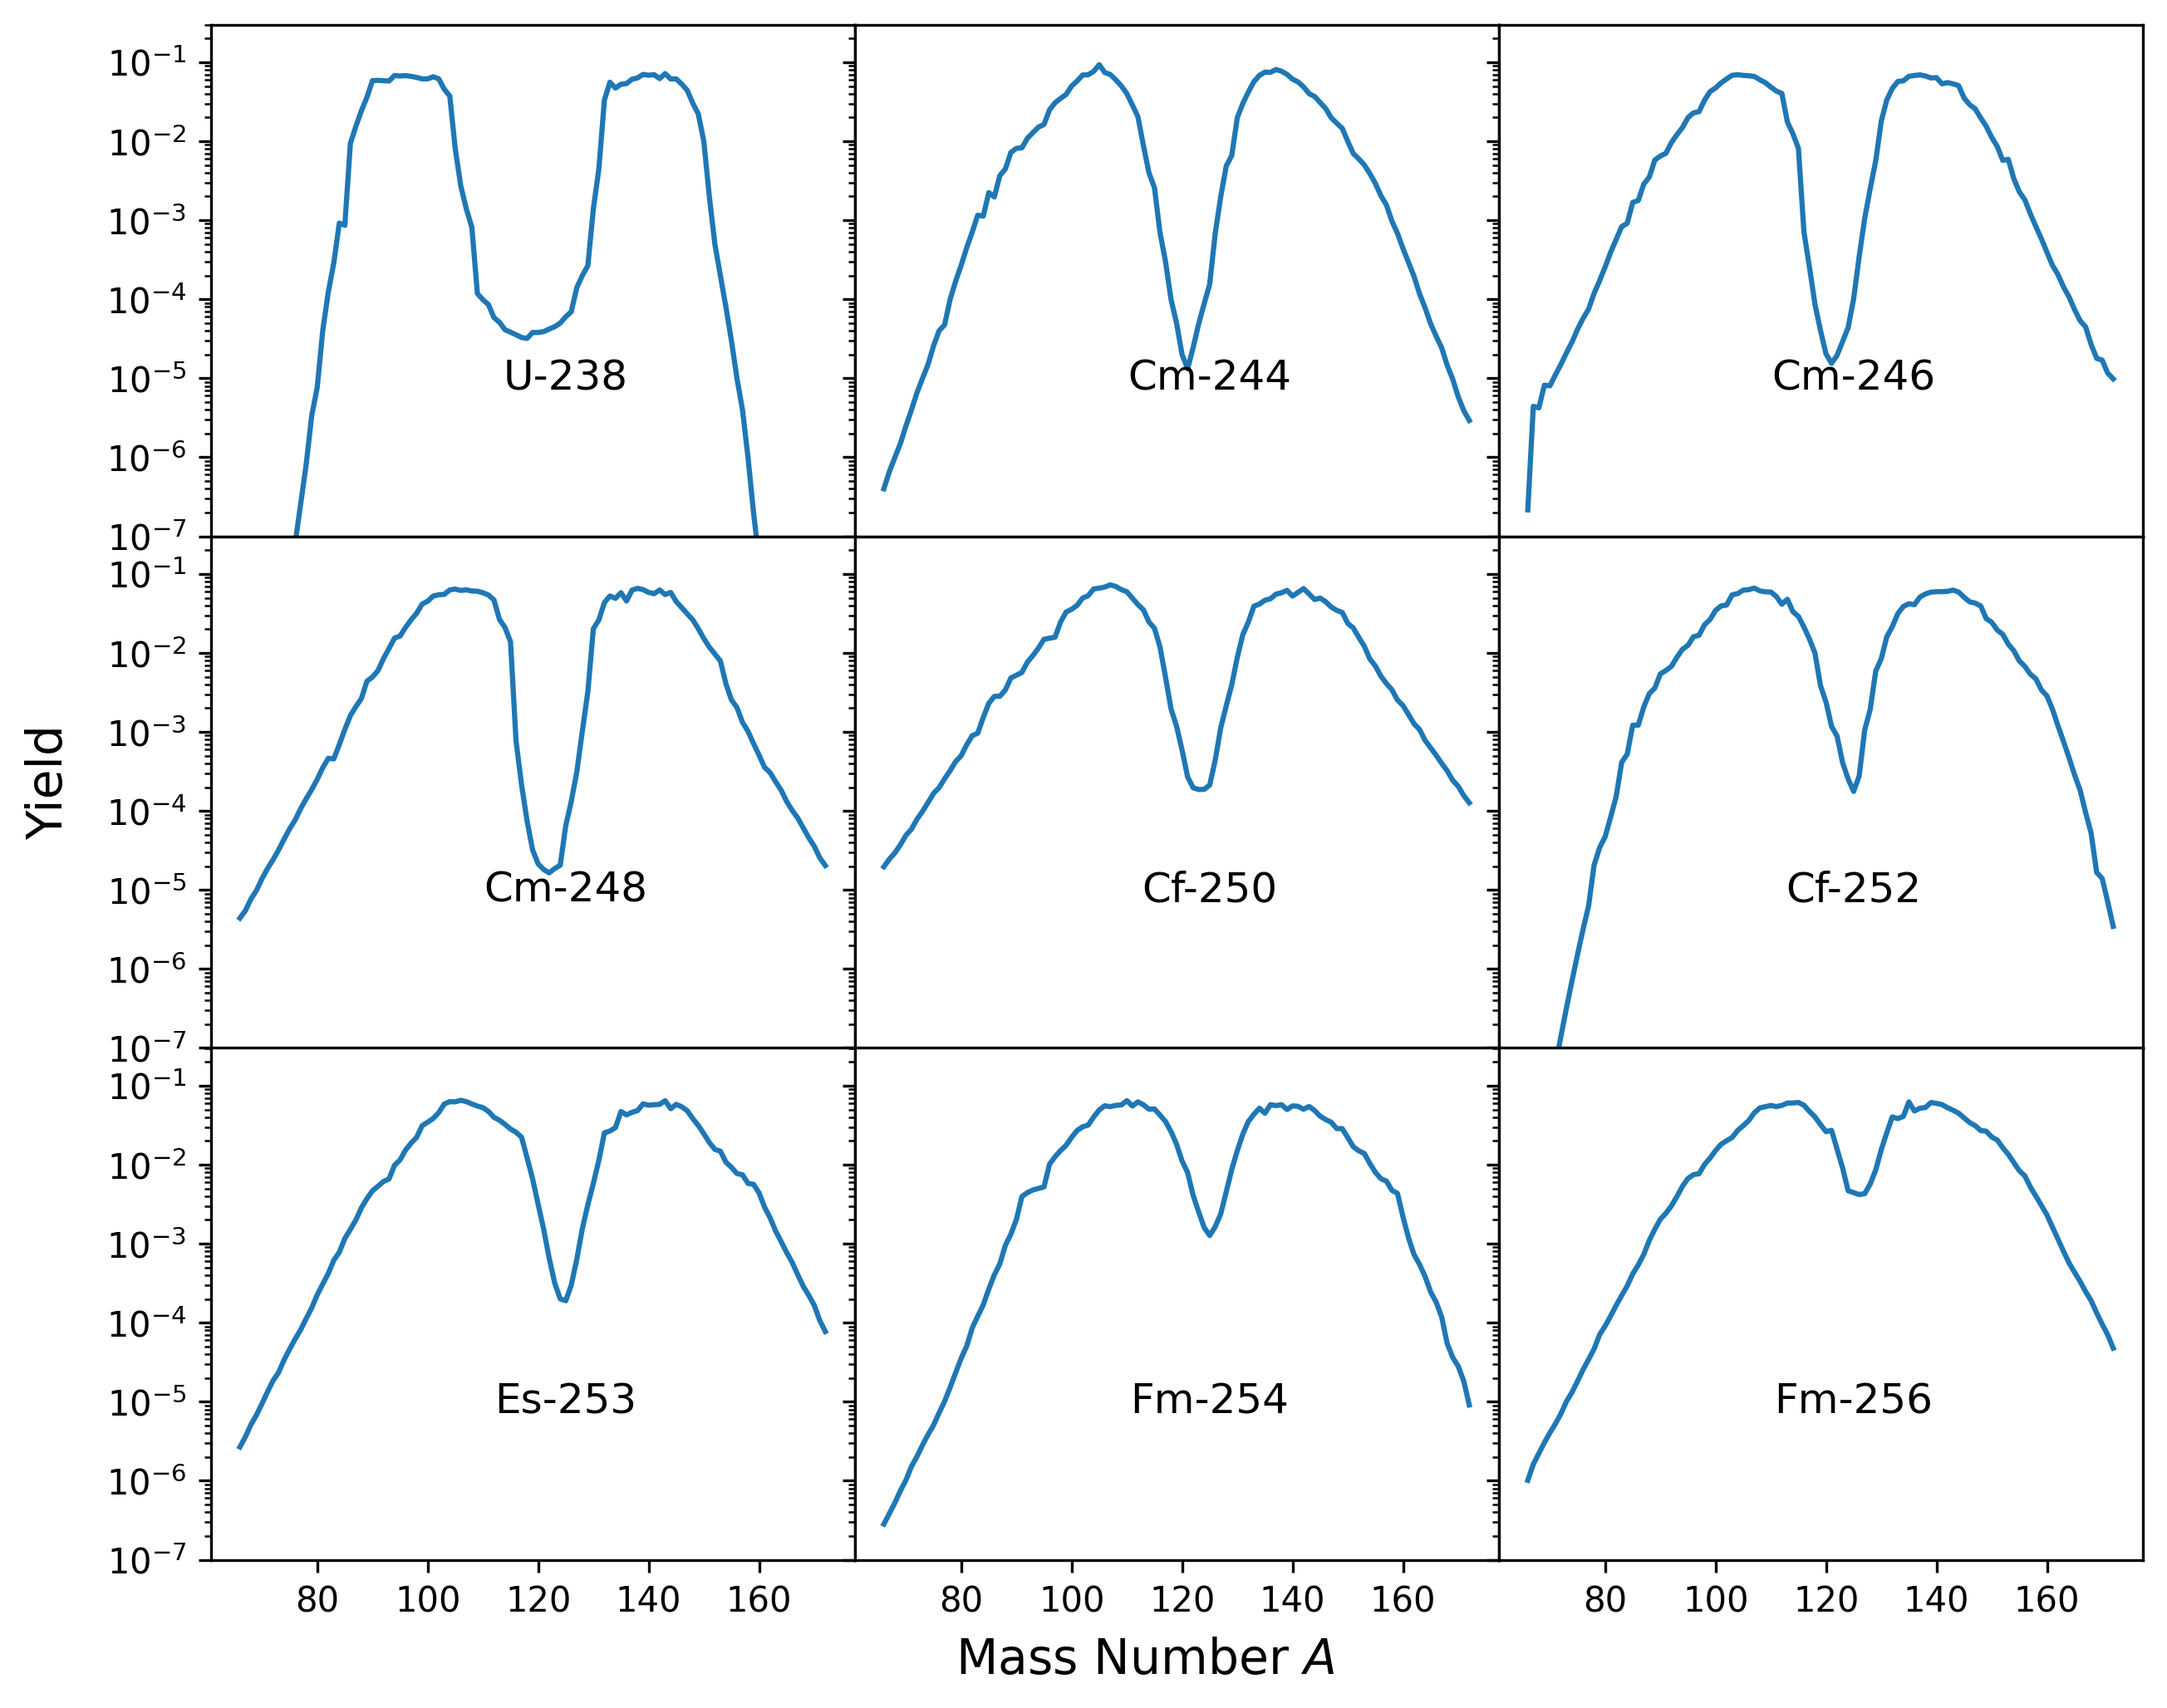

In [3]:
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().resolve().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nudca.utils import DecayDatabaseManager

df_sf = pd.read_csv(Path.cwd().resolve().parent.joinpath('data/ENDF-B-VIII.1_SF.csv'))
df_sf = DecayDatabaseManager.parse_string_to_list(df_sf, 'Mass_Number')
df_sf = DecayDatabaseManager.parse_string_to_list(df_sf, 'Proton_Number')
df_sf = DecayDatabaseManager.parse_string_to_list(df_sf, 'Yield')
df_df = DecayDatabaseManager.parse_string_to_list(df_sf, 'Fragment')
# df_sf = df_sf[df_sf['Radionuclide'] == 'Cf-252']

df_sf.sort_values(by=['A', 'Z'], ascending=True, inplace=True)
radionuclides = df_sf['Radionuclide'].to_list()


fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 8), sharex=True, sharey=True, dpi=300)
for ax, radionuclide in zip(axs.flat, radionuclides):
    df = df_sf[df_sf['Radionuclide'] == radionuclide]
    Z = np.array(df['Proton_Number'].to_list()[0], dtype=int)
    A = np.array(df['Mass_Number'].to_list()[0], dtype=int)
    Yield = np.array(df['Yield'].to_list()[0], dtype=float)

    # mask = Yield >= 1.e-3
    # Z = Z[mask]
    # A = A[mask]
    # Yield = Yield[mask]

    results = {}
    for a, y in zip(A, Yield) :
        if not a in results : results[a] = 0
        results[a] += y

    mass = sorted(list(set(results.keys())))
    yields = [results[value] for value in mass]

    ax.plot(mass, yields)
    # ax.scatter(mass, yields)
    # ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-7, 3e-1)
    ax.text(125, 1e-5, radionuclide, ha='center', va='center', fontsize=12)

fig.text(0.5, 0.06, r'Mass Number $A$', ha='center', va='center', fontsize=14)
fig.text(0.06, 0.5, r'Yield', ha='center', va='center', rotation='vertical', fontsize=14)

plt.subplots_adjust(hspace=0.0, wspace=0.0)
plt.show()

fig.savefig('SF_Fragments.png', dpi=300, bbox_inches='tight')

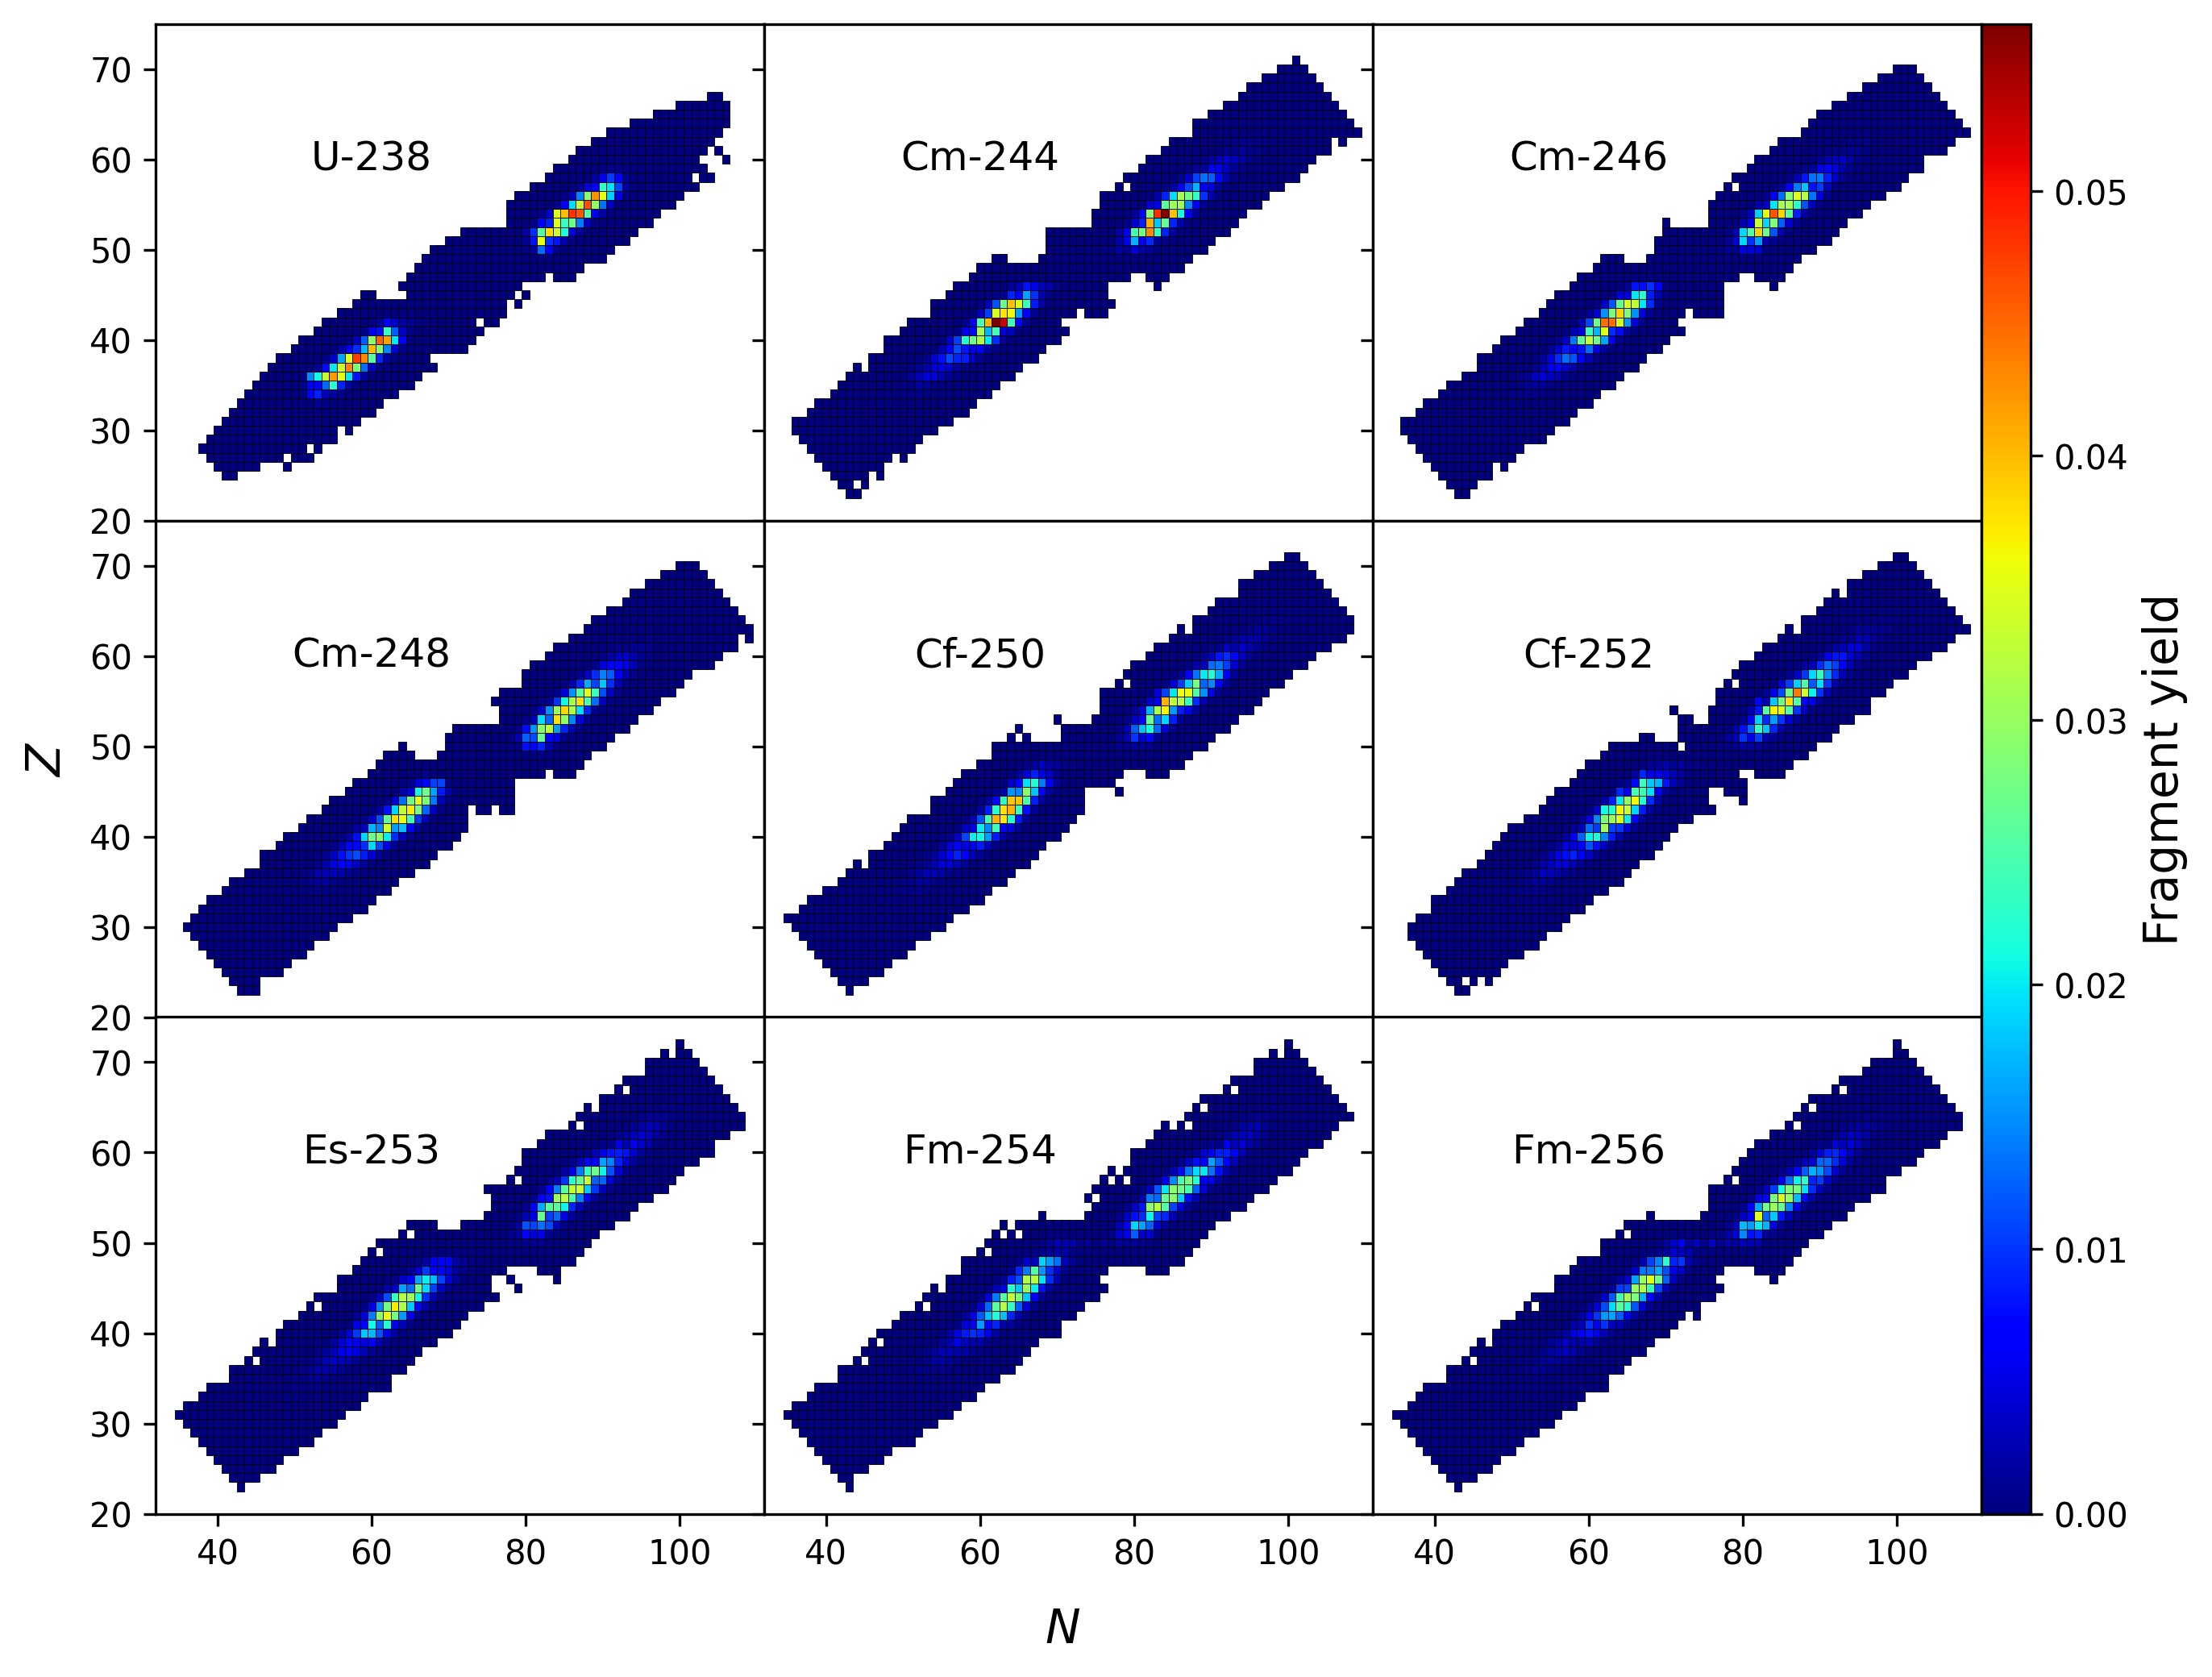

In [1]:
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().resolve().parent))

import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from matplotlib import gridspec

from nudca.utils import DecayDatabaseManager

df_sf = pd.read_csv(Path.cwd().resolve().parent.joinpath('data/ENDF-B-VIII.1_SF.csv'))
df_sf = DecayDatabaseManager.parse_string_to_list(df_sf, 'Mass_Number')
df_sf = DecayDatabaseManager.parse_string_to_list(df_sf, 'Proton_Number')
df_sf = DecayDatabaseManager.parse_string_to_list(df_sf, 'Yield')
df_sf = DecayDatabaseManager.parse_string_to_list(df_sf, 'Fragment')

df_sf.sort_values(by=['A', 'Z'], ascending=True, inplace=True)
radionuclides = df_sf['Radionuclide'].to_list()


min_yield = 1e-50
all_yields = []
for idx, row in df_sf.iterrows():
    all_yields.extend(row['Yield'])
all_yields = np.array(all_yields, dtype=float)
vmin = np.min(min_yield)
vmax = np.max(all_yields)


fig = plt.figure(figsize=(10, 8), dpi=300)
gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 1, 0.08], wspace=0.0, hspace=0.0)
cmap = plt.get_cmap('jet')
norm = plt.Normalize(vmin=vmin, vmax=vmax)
# axs = [fig.add_subplot(gs[i, j]) for i in range(3) for j in range(3)]

axs = []
for i in range(3):
    for j in range(3):
        if i == 0 and j == 0:
            ax = fig.add_subplot(gs[i, j])
            axs.append(ax)
        else:
            ax = fig.add_subplot(gs[i, j], sharex=axs[0], sharey=axs[0])
            axs.append(ax)

cbar_ax = fig.add_subplot(gs[:, 3])


for ax, radionuclide in zip(axs, radionuclides):
    df = df_sf[df_sf['Radionuclide'] == radionuclide]
    Z = np.array(df['Proton_Number'].to_list()[0], dtype=int)
    A = np.array(df['Mass_Number'].to_list()[0], dtype=int)
    N = A - Z
    Yield = np.array(df['Yield'].to_list()[0], dtype=float)

    mask = Yield >= min_yield
    Z = Z[mask]
    N = N[mask]
    Yield = Yield[mask]

    for n, z, y in zip(N, Z, Yield):
        color = cmap(norm(y))
        ax.add_patch(Rectangle((n-0.5, z-0.5), 1, 1, facecolor=color, edgecolor='k', linewidth=0.2))

    ax.set_xlim(min(N)-3, max(N)+3)
    ax.set_ylim(min(Z)-3, max(Z)+3)
    ax.text(60, 60, radionuclide, ha='center', va='center', fontsize=12)

for idx, ax in enumerate(axs):
    if idx % 3 == 0:
        ax.tick_params(labelleft=True)
    else:
        ax.tick_params(labelleft=False)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Fragment yield', fontsize=14)

fig.text(0.5, 0.05, r'$N$', ha='center', va='center', fontsize=14)
fig.text(0.08, 0.5, r'$Z$', ha='center', va='center', rotation='vertical', fontsize=14)

plt.subplots_adjust(hspace=0.0, wspace=0.0)
plt.show()

fig.savefig('SF.png', dpi=300, bbox_inches='tight')

In [ ]:
def plot_stable_nuclei(
    ax: plt.Axes,
    stable_nuclides,
    nuclei_linewidths
) -> None:
    """Plot stable nuclei in black."""
    for N, Z in stable_nuclides:
        ax.add_patch(
            Rectangle(
                (N-0.5, Z-0.5), 1, 1,
                facecolor='black',
                edgecolor='black',
                linewidth=nuclei_linewidths
            )
        )


def _mark_magic_numbers(
    ax: plt.Axes,
    magic_numbers,
    range_groups,
    stable_nuclides
) -> None:
    """Mark magic numbers on the nuclear chart."""
    for magic_number in magic_numbers:
        magic_N_nuclides = []
        magic_Z_nuclides = []
        
        # Check stable nuclides
        for N, Z in stable_nuclides:
            if N == magic_number:
                magic_N_nuclides.append((N, Z))
            if Z == magic_number:
                magic_Z_nuclides.append((N, Z))
        
        # Check unstable nuclides
        for nuclides in range_groups.values():
            for N, Z, _ in nuclides:
                if N == magic_number:
                    magic_N_nuclides.append((N, Z))
                if Z == magic_number:
                    magic_Z_nuclides.append((N, Z))
        
        # Highlight neutron magic number
        if magic_N_nuclides:
            Z_values = [Z for _, Z in magic_N_nuclides]
            Z_min, Z_max = min(Z_values), max(Z_values)
            ax.add_patch(
                Rectangle(
                    (magic_number-0.5, Z_min-0.5), 1, Z_max - Z_min + 1,
                    fill=False,
                    edgecolor='black',
                    linewidth=0.8,
                    linestyle='--',
                    zorder=5
                )
            )
        
        # Mark proton magic number
        if magic_Z_nuclides:
            N_values = [N for N, _ in magic_Z_nuclides]
            N_min, N_max = min(N_values), max(N_values)
            ax.add_patch(Rectangle(
                (N_min-0.5, magic_number-0.5), N_max - N_min + 1, 1,
                fill=False, edgecolor='black', linewidth=0.8, linestyle='--', zorder=5
            ))

def _get_axis_limits(
    range_groups,
    stable_nuclides
):
    """Get all N and Z values for axis limits."""
    all_N_values = []
    all_Z_values = []
    
    for nuclides in range_groups.values():
        for N, Z, _ in nuclides:
            all_N_values.append(N)
            all_Z_values.append(Z)
            
    for N, Z in stable_nuclides:
        all_N_values.append(N)
        all_Z_values.append(Z)
        
    return all_N_values, all_Z_values